## Dataset loading


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

train = pd.read_csv("/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv")
test = pd.read_csv("/kaggle/input/customer-churn-dataset/customer_churn_dataset-testing-master.csv")

print("Datasets Loaded Successfully!")
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

# Combine for consistent encoding
data = pd.concat([train, test], ignore_index=True)

print("\nColumns:")
print(list(data.columns))


Datasets Loaded Successfully!
Train Shape: (440833, 12)
Test Shape: (64374, 12)

Columns:
['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn']


## Preprocessing

In [ ]:
# Fill missing values
for col in data.columns:
    if data[col].dtype in [np.float64, np.int64]:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Clip outliers (1st–99th percentile)
num_cols = data.select_dtypes(include=[np.number]).columns
for col in num_cols:
    q1, q3 = data[col].quantile([0.01, 0.99])
    data[col] = data[col].clip(q1, q3)

print(" Data cleaned successfully!")


 Data cleaned successfully!


## Encoding

In [ ]:
# --- Encoding categorical columns using pd.get_dummies() ---
print("\nEncoding categorical columns...")

# Drop CustomerID if present
if 'CustomerID' in data.columns:
    data.drop(columns=['CustomerID'], inplace=True)
    print("Dropped 'CustomerID' column (identifier).")

cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns detected:", cat_cols)

# Apply one-hot encoding
data_encoded = pd.get_dummies(data, columns=cat_cols, drop_first=False)

print(f"Encoding complete! Total features after encoding: {data_encoded.shape[1]}")
print("Example encoded columns:", data_encoded.columns.tolist())

if 'Churn' not in data_encoded.columns:
    raise KeyError("The target column 'Churn' was not found after encoding. Check your dataset column names!")

X = data_encoded.drop('Churn', axis=1)
y = data_encoded['Churn']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nData Split Done Successfully!")
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape : {X_test.shape}")



Encoding categorical columns...
Dropped 'CustomerID' column (identifier).
Categorical columns detected: ['Gender', 'Subscription Type', 'Contract Length']
Encoding complete! Total features after encoding: 16
Example encoded columns: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn', 'Gender_Female', 'Gender_Male', 'Subscription Type_Basic', 'Subscription Type_Premium', 'Subscription Type_Standard', 'Contract Length_Annual', 'Contract Length_Monthly', 'Contract Length_Quarterly']

Data Split Done Successfully!
Training Shape: (404165, 15)
Testing Shape : (101042, 15)


In [ ]:
print("\n Encoded Columns:")
for i, col in enumerate(data_encoded.columns):
    print(f"{i+1:>3}. {col}")



 Encoded Columns:
  1. Age
  2. Tenure
  3. Usage Frequency
  4. Support Calls
  5. Payment Delay
  6. Total Spend
  7. Last Interaction
  8. Churn
  9. Gender_Female
 10. Gender_Male
 11. Subscription Type_Basic
 12. Subscription Type_Premium
 13. Subscription Type_Standard
 14. Contract Length_Annual
 15. Contract Length_Monthly
 16. Contract Length_Quarterly


In [ ]:
data_encoded

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
0,30.0,39.0,14.0,5.0,18.0,932.0,17.0,1.0,True,False,False,False,True,True,False,False
1,65.0,49.0,1.0,10.0,8.0,557.0,6.0,1.0,True,False,True,False,False,False,True,False
2,55.0,14.0,4.0,6.0,18.0,185.0,3.0,1.0,True,False,True,False,False,False,False,True
3,58.0,38.0,21.0,7.0,7.0,396.0,29.0,1.0,False,True,False,False,True,False,True,False
4,23.0,32.0,20.0,5.0,8.0,617.0,20.0,1.0,False,True,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505202,45.0,33.0,12.0,6.0,21.0,947.0,14.0,1.0,True,False,True,False,False,False,False,True
505203,37.0,6.0,1.0,5.0,22.0,923.0,9.0,1.0,False,True,False,False,True,True,False,False
505204,25.0,39.0,14.0,8.0,30.0,327.0,20.0,1.0,False,True,False,True,False,False,True,False
505205,50.0,18.0,19.0,7.0,22.0,540.0,13.0,1.0,True,False,False,False,True,False,True,False


## Model building & evaluation


 Training Random Forest model...
 Model trained successfully!
 Training Accuracy: 0.9333
 Testing Accuracy : 0.9329


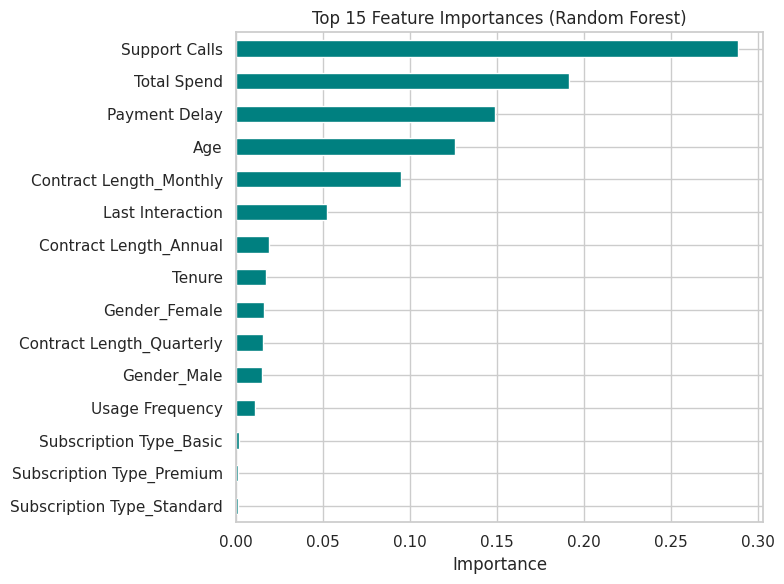

In [ ]:

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

print("\n Training Random Forest model...")

rf = RandomForestClassifier(
    n_estimators=500,         # number of trees
    max_depth=15,             # limit depth to prevent overfitting
    min_samples_split=5,      # min samples required to split an internal node
    min_samples_leaf=3,       # min samples required at each leaf node
    max_features='sqrt',      # try a subset of features for each split
    bootstrap=True,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1                 # use all cores for speed
)

rf.fit(X_train, y_train)

print(" Model trained successfully!")

train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)
print(f" Training Accuracy: {train_acc:.4f}")
print(f" Testing Accuracy : {test_acc:.4f}")

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
top_features.plot(kind='barh', color='teal')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



🔹 Using Custom Threshold: 0.4


 FULL MODEL PERFORMANCE SUMMARY:



,Metric,Class 0 (Not Churn),Class 1 (Churn),Model (Macro Avg)
0,Accuracy,0.935,0.935,0.935
1,Precision,0.993,0.898,0.946
2,Recall,0.859,0.995,0.927
3,F1-score,0.921,0.944,0.933
4,ROC AUC,0.953,0.953,0.953
5,Specificity,0.859,0.995,0.927



 CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Not Churn (0)       0.99      0.86      0.92     44943
    Churn (1)       0.90      1.00      0.94     56099

     accuracy                           0.93    101042
    macro avg       0.95      0.93      0.93    101042
 weighted avg       0.94      0.93      0.93    101042



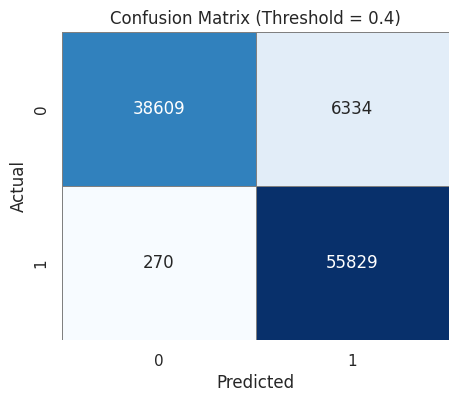

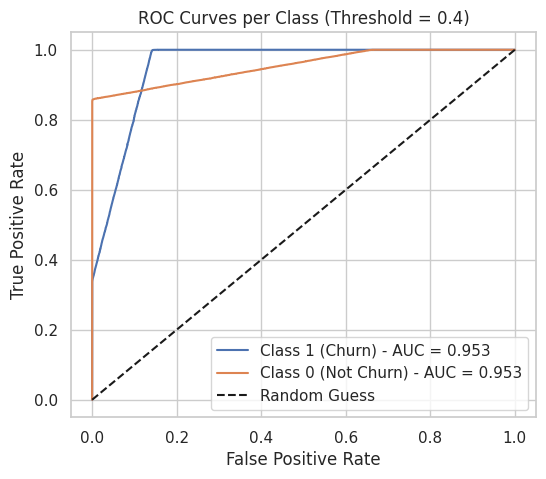


Global ROC AUC (overall model): 0.953


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

threshold = 0.4

y_proba = rf.predict_proba(X_test)[:, 1]  # Probability of churn=1
y_pred = (y_proba >= threshold).astype(int)  # Apply custom threshold

print(f"\n Using Custom Threshold: {threshold}\n")

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# --- Overall model metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')
roc_auc_macro = roc_auc_score(y_test, y_proba)

# --- Per-class metrics ---
# Class 0 (Not Churn)
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)
roc_auc_0 = roc_auc_score(1 - y_test, 1 - y_proba)
specificity_0 = tn / (tn + fp)

# Class 1 (Churn)
precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc_1 = roc_auc_score(y_test, y_proba)
specificity_1 = tp / (tp + fn)  

metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'Specificity'],
    'Class 0 (Not Churn)': [
        round(accuracy, 3), round(precision_0, 3), round(recall_0, 3),
        round(f1_0, 3), round(roc_auc_0, 3), round(specificity_0, 3)
    ],
    'Class 1 (Churn)': [
        round(accuracy, 3), round(precision_1, 3), round(recall_1, 3),
        round(f1_1, 3), round(roc_auc_1, 3), round(specificity_1, 3)
    ],
    'Model (Macro Avg)': [
        round(accuracy, 3), round(precision_macro, 3), round(recall_macro, 3),
        round(f1_macro, 3), round(roc_auc_macro, 3), round((specificity_0 + specificity_1)/2, 3)
    ]
})

print("\n FULL MODEL PERFORMANCE SUMMARY:\n")
display(metrics_table)

print("\n CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=["Not Churn (0)", "Churn (1)"]))

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5, linecolor='gray')
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr_1, tpr_1, _ = roc_curve(y_test, y_proba, pos_label=1)
fpr_0, tpr_0, _ = roc_curve(1 - y_test, 1 - y_proba, pos_label=1)

plt.figure(figsize=(6, 5))
plt.plot(fpr_1, tpr_1, label=f"Class 1 (Churn) - AUC = {roc_auc_1:.3f}")
plt.plot(fpr_0, tpr_0, label=f"Class 0 (Not Churn) - AUC = {roc_auc_0:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves per Class (Threshold = {threshold})")
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nGlobal ROC AUC (overall model): {roc_auc:.3f}")



 Generating Partial Dependence (PDP) + ICE plots with progress bar...
Top features used for PDP/ICE: ['Support Calls', 'Total Spend', 'Payment Delay']


Processing PDP+ICE for features:   0%|          | 0/3 [00:00<?, ?it/s]

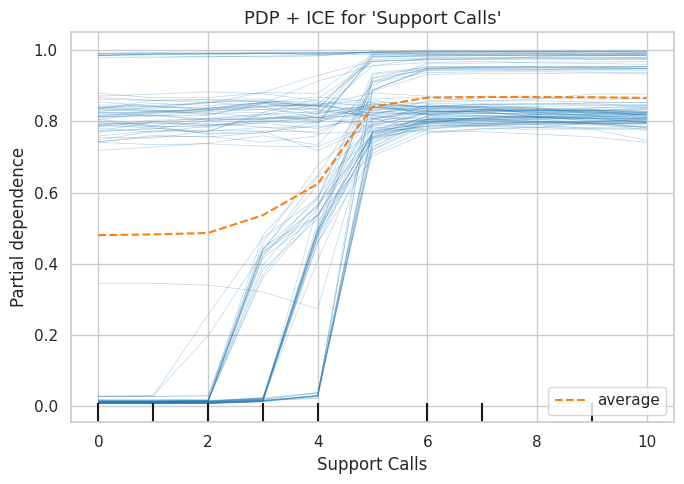

Processing PDP+ICE for features:  33%|███▎      | 1/3 [00:34<01:09, 34.91s/it]

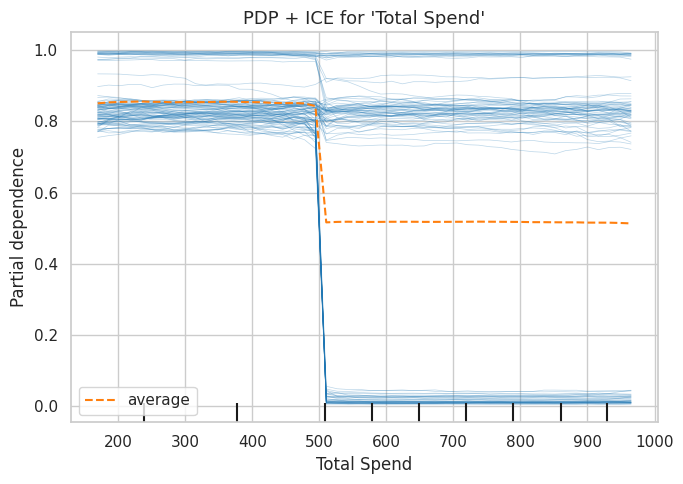

Processing PDP+ICE for features:  67%|██████▋   | 2/3 [02:59<01:39, 99.34s/it]

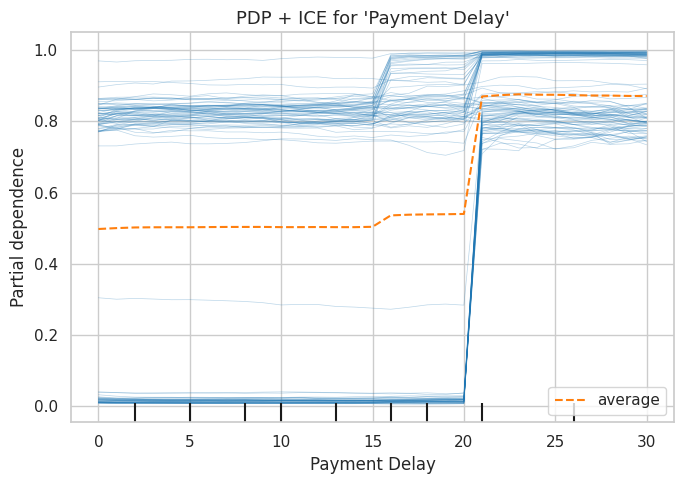

Processing PDP+ICE for features: 100%|██████████| 3/3 [04:29<00:00, 89.92s/it]


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

print("\n Generating Partial Dependence (PDP) + ICE plots with progress bar...")

# --- Select top features from feature importances ---
top_features = importances.sort_values(ascending=False).head(3).index.tolist()
print(f"Top features used for PDP/ICE: {top_features}")

for feature in tqdm(top_features, desc="Processing PDP+ICE for features", colour="cyan"):
    fig, ax = plt.subplots(figsize=(7, 5))
    
    PartialDependenceDisplay.from_estimator(
        rf,
        X_test,
        features=[feature],
        kind='both',  # PDP + ICE overlay
        subsample=100,  # sample for speed
        n_jobs=-1,
        grid_resolution=50,
        ax=ax
    )

    plt.title(f"PDP + ICE for '{feature}'", fontsize=13)
    plt.tight_layout()
    plt.show()



Generating 2D Interaction PDPs for Top Features on a Subset (100 samples)...

 Selected Top 3 Features for Interaction Analysis: ['Support Calls', 'Total Spend', 'Payment Delay']

 Using subset of size: 100

Total Interaction Pairs to Plot: 3



 Plotting 2D PDP Interactions:   0%|          | 0/3 [00:00<?, ?it/s]

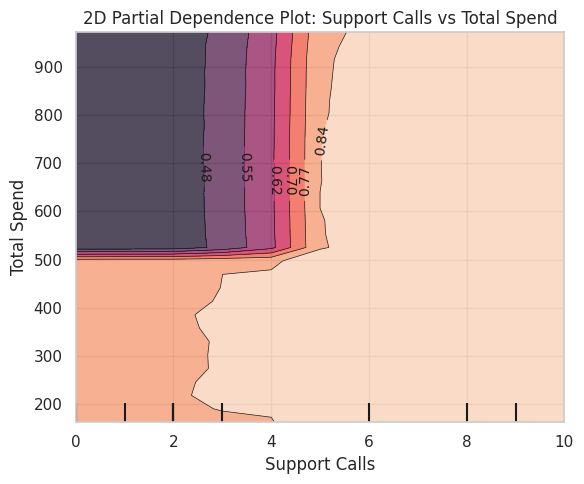

 Plotting 2D PDP Interactions:  33%|███▎      | 1/3 [00:38<01:17, 38.56s/it]

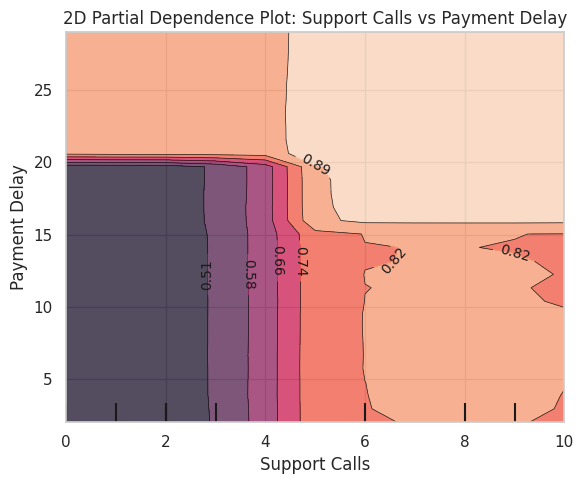

 Plotting 2D PDP Interactions:  67%|██████▋   | 2/3 [01:16<00:37, 37.91s/it]

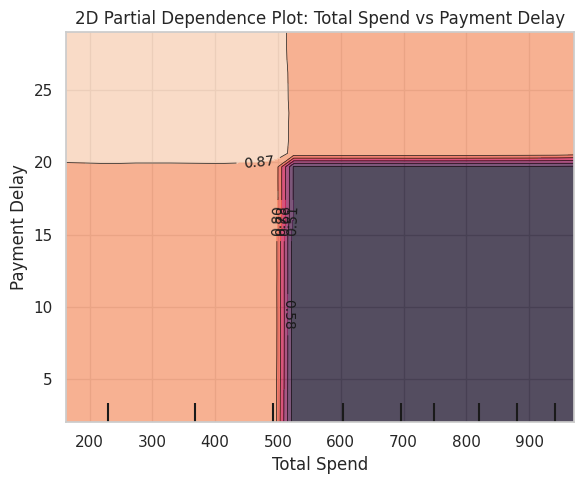

 Plotting 2D PDP Interactions: 100%|██████████| 3/3 [02:51<00:00, 57.11s/it]


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

print("\nGenerating 2D Interaction PDPs for Top Features on a Subset (100 samples)...\n")

top_features = importances.sort_values(ascending=False).head(3).index.tolist()
print(f" Selected Top 3 Features for Interaction Analysis: {top_features}\n")

subset_size = min(100, X_test.shape[0])
X_pdp = X_test.sample(subset_size, random_state=42)
print(f" Using subset of size: {subset_size}\n")

feature_pairs = list(itertools.combinations(top_features, 2))
print(f"Total Interaction Pairs to Plot: {len(feature_pairs)}\n")

for pair in tqdm(feature_pairs, desc=" Plotting 2D PDP Interactions"):
    fig, ax = plt.subplots(figsize=(6, 5))
    PartialDependenceDisplay.from_estimator(
        rf,
        X_pdp,
        features=[pair],
        kind='average',        # average PDP (2D heatmap)
        grid_resolution=30,
        n_jobs=-1,
        ax=ax
    )
    plt.title(f"2D Partial Dependence Plot: {pair[0]} vs {pair[1]}", fontsize=12)
    plt.tight_layout()
    plt.show()


In [ ]:
!pip install dice-ml --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.3 MB/s eta 0:00:00


In [ ]:
import dice_ml
from dice_ml import Dice


In [ ]:
import shap
import numpy as np
import pandas as pd
import dice_ml
from dice_ml import Dice
from tqdm import tqdm

def ensure_numeric(df):
    """Converts booleans and object columns to numeric."""
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
        elif df[col].dtype == 'object':
            df[col] = pd.factorize(df[col])[0]
    return df

X_train_num = ensure_numeric(X_train)
X_test_num = ensure_numeric(X_test)

print("\nComputing SHAP values on a subset of 100 samples...\n")
subset_size = min(100, X_train_num.shape[0])
X_shap = X_train_num.sample(subset_size, random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_shap, check_additivity=False)

target_class = input("Enter target class ('churn' or 'not churn'): ").strip().lower()
sample_index = int(input(f"Enter sample index (0 to {len(X_test_num)-1}): "))

x_instance = X_test_num.iloc[[sample_index]].copy()
orig_pred = rf.predict(x_instance)[0]
orig_proba = rf.predict_proba(x_instance)[:, 1][0]
print(f"\nOriginal Prediction: {'Churn' if orig_pred==1 else 'Not Churn'} (Prob={orig_proba:.3f})")

shap_instance = explainer.shap_values(x_instance, check_additivity=False)
class_idx = 1 if target_class == "churn" else 0

instance_shap_df = pd.DataFrame({
    "feature": X_test_num.columns,
    "shap_value": shap_instance[class_idx][0],
    "value": x_instance.values[0]
})

# Lock immutable features
fixed_features = ["Age", "Gender_Male", "Gender_Female"]
instance_shap_df = instance_shap_df[~instance_shap_df["feature"].isin(fixed_features)]

# Select Top 3 most influential SHAP features
top_features = (
    instance_shap_df
    .reindex(instance_shap_df["shap_value"].abs().sort_values(ascending=False).index)
    .head(3)["feature"]
    .tolist()
)
print(f"\nTop 3 influential features toward '{target_class}': {top_features}")

data_for_dice = pd.concat([X_train_num, y_train.reset_index(drop=True)], axis=1)
data_for_dice.rename(columns={'Churn': 'target'}, inplace=True)

d = dice_ml.Data(
    dataframe=data_for_dice,
    continuous_features=X_train_num.select_dtypes(include=[float, int]).columns.tolist(),
    outcome_name='target'
)

m = dice_ml.Model(model=rf, backend='sklearn')
exp = Dice(d, m, method='random')

desired_class = 0 if orig_pred == 1 else 1
print(f"\nGenerating counterfactuals to flip → {'Not Churn' if desired_class==0 else 'Churn'}...\n")

dice_cf = exp.generate_counterfactuals(
    x_instance,
    total_CFs=3,
    desired_class=desired_class,
    features_to_vary=top_features
)

dice_cf.visualize_as_dataframe(show_only_changes=True)



Computing SHAP values on a subset of 100 samples...



Enter target class ('churn' or 'not churn'):  churn
Enter sample index (0 to 101041):  17000



Original Prediction: Churn (Prob=0.772)

Top 3 influential features toward 'churn': ['Total Spend', 'Support Calls', 'Payment Delay']

Generating counterfactuals to flip → Not Churn...



100%|██████████| 1/1 [00:02<00:00,  2.54s/it]

Query instance (original outcome : 1.0)


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,target
0,34.0,16.0,12.0,0.0,8.0,392.0,12.0,0,1,0,1,0,0,0,1,1.0



Diverse Counterfactual set (new outcome: 0.0)


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,target
0,-,-,-,-,-,800.0,-,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,8.3,711.4,-,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,11.2,650.0,-,-,-,-,-,-,-,-,-,0.0


Enter target class ('churn' or 'not churn'):   churn
Enter sample index (0 to 101041):  3791



Original Prediction: Churn (Prob=0.859)

🔍 Generating SHAP Waterfall plot for class 'churn' (sample 3791)...



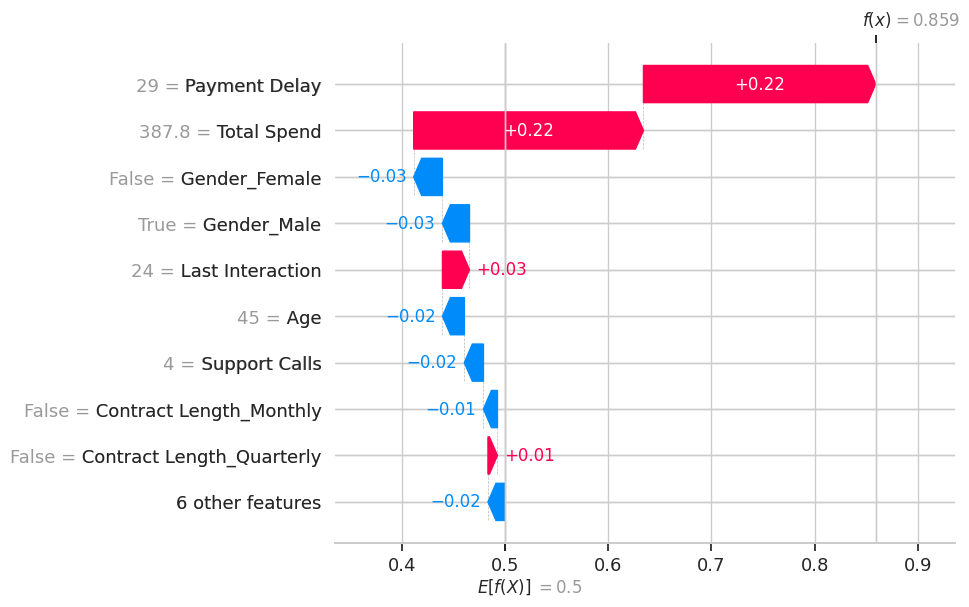


Top 3 influential features toward 'churn': ['Payment Delay', 'Total Spend', 'Last Interaction']


⚡ Generating counterfactuals to flip → Not Churn...



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

Diverse Counterfactuals found! total time taken: 00 min 01 sec

Counterfactual examples generated (showing only changes):

Query instance (original outcome : 1.0)


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,target
0,45.0,19.0,17.0,4.0,29.0,387.799988,24.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0



Diverse Counterfactual set (new outcome: 0.0)


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,target
0,-,-,-,-,18.8,898.3,-,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,13.2,606.2,-,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,2.6,794.5,-,-,-,-,-,-,-,-,-,0.0


In [ ]:

import shap
import dice_ml
from dice_ml import Dice
from tqdm import tqdm
import pandas as pd
import numpy as np

target_class = input("Enter target class ('churn' or 'not churn'): ").strip().lower()
sample_index = int(input(f"Enter sample index (0 to {len(X_test)-1}): "))

x_instance = X_test.iloc[[sample_index]]
y_pred = rf.predict_proba(x_instance)[:, 1][0]
orig_class = "churn" if y_pred >= 0.5 else "not churn"

print(f"\nOriginal Prediction: {orig_class.capitalize()} (Prob={y_pred:.3f})")

shap_instance = explainer.shap_values(x_instance, check_additivity=False)
class_idx = 1 if target_class == "churn" else 0

print(f"\n Generating SHAP Waterfall plot for class '{target_class}' (sample {sample_index})...\n")

shap.plots.waterfall(
    shap.Explanation(
        values=shap_instance[class_idx][0],
        base_values=explainer.expected_value[class_idx],
        data=x_instance.values[0],
        feature_names=X_test.columns
    )
)

instance_shap_df = pd.DataFrame({
    "feature": X_test.columns,
    "value": x_instance.values[0],
    "shap_value": shap_instance[class_idx][0]
})

fixed_features = ["Age", "Gender_Male", "Gender_Female"]
instance_shap_df = instance_shap_df[~instance_shap_df["feature"].isin(fixed_features)]

top_features = instance_shap_df.reindex(
    instance_shap_df["shap_value"].abs().sort_values(ascending=False).index
).head(3)["feature"].tolist()

print(f"\nTop 3 influential features toward '{target_class}': {top_features}\n")

X_train_dice = X_train.copy().apply(lambda col: col.astype(float) if col.dtype == bool else col)
X_test_dice = X_test.copy().apply(lambda col: col.astype(float) if col.dtype == bool else col)

data_dice = dice_ml.Data(
    dataframe=pd.concat([X_train_dice, y_train.rename("target")], axis=1),
    continuous_features=[c for c in X_train_dice.columns if np.issubdtype(X_train_dice[c].dtype, np.number)],
    outcome_name='target'
)

model_dice = dice_ml.Model(model=rf, backend="sklearn")
exp = Dice(data_dice, model_dice, method="random")

desired_class = 0 if orig_class == "churn" else 1
print(f"\n Generating counterfactuals to flip → {'Not Churn' if orig_class=='churn' else 'Churn'}...\n")

dice_cf = exp.generate_counterfactuals(
    X_test_dice.iloc[[sample_index]],
    total_CFs=3,
    desired_class=desired_class,
    features_to_vary=top_features,
    verbose=True
)

print("\nCounterfactual examples generated (showing only changes):\n")
dice_cf.visualize_as_dataframe(show_only_changes=True)


Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn':  churn



Found 61863 test samples predicted as 'churn'.


Enter subset index (0..61862):  1349



Selected global test index: 2116
Original model prediction: 1 (Prob_Churn=0.826)

🔍 SHAP Waterfall for selected instance...



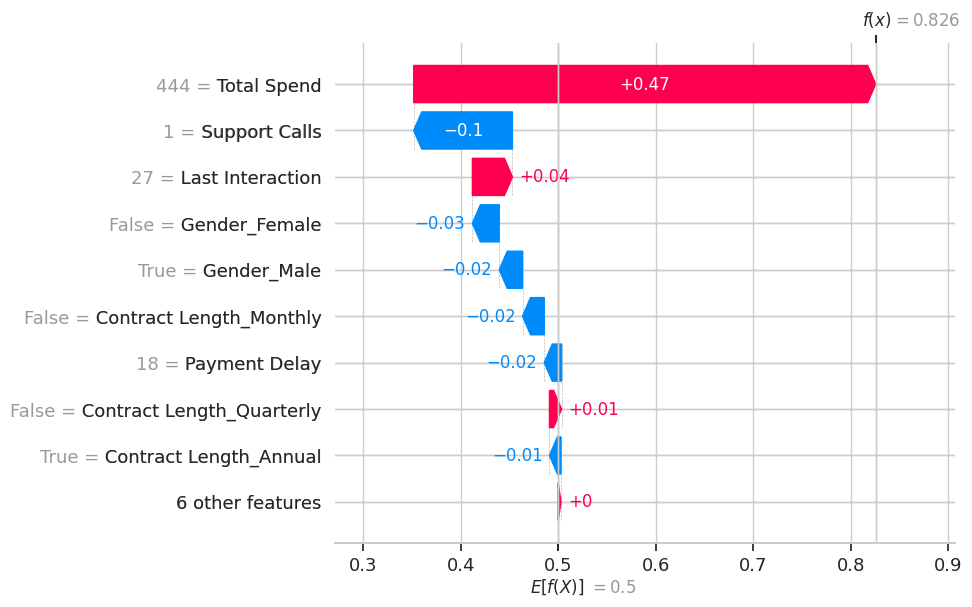


Top 10 SHAP contributions (descending importance):


,Feature,Value,SHAP,|SHAP|
5,Total Spend,444.0,0.473805,0.473805
3,Support Calls,1.0,-0.101259,0.101259
6,Last Interaction,27.0,0.041078,0.041078
7,Gender_Female,False,-0.027551,0.027551
8,Gender_Male,True,-0.023877,0.023877
13,Contract Length_Monthly,False,-0.022299,0.022299
4,Payment Delay,18.0,-0.017760,0.017760
14,Contract Length_Quarterly,False,0.012432,0.012432
12,Contract Length_Annual,True,-0.011822,0.011822
0,Age,23.0,-0.008324,0.008324



Top 3 influential features allowed to vary: ['Total Spend', 'Support Calls', 'Last Interaction']

⚡ Generating counterfactuals to flip → class 0 ...



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Diverse Counterfactuals found! total time taken: 00 min 01 sec

=== Counterfactual examples (full rows) ===


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,target
0,23.0,39.0,10.0,1.0,18.0,735.3,27.0,0,1,1,0,0,1,0,0,0.0
1,23.0,39.0,10.0,1.0,18.0,769.5,24.6,0,1,1,0,0,1,0,0,0.0
2,23.0,39.0,10.0,1.0,18.0,560.2,14.7,0,1,1,0,0,1,0,0,0.0



=== Changed features per counterfactual ===

⚡ Counterfactual #1
  • Total Spend: 444.0 → 735.3

⚡ Counterfactual #2
  • Total Spend: 444.0 → 769.5
  • Last Interaction: 27.0 → 24.6

⚡ Counterfactual #3
  • Total Spend: 444.0 → 560.2
  • Last Interaction: 27.0 → 14.7

=== Model probabilities for Original and CFs ===


,Instance,Prob_Churn,Predicted_Class
0,Original,0.826,1
1,CF1,0.017,0
2,CF2,0.017,0
3,CF3,0.015,0


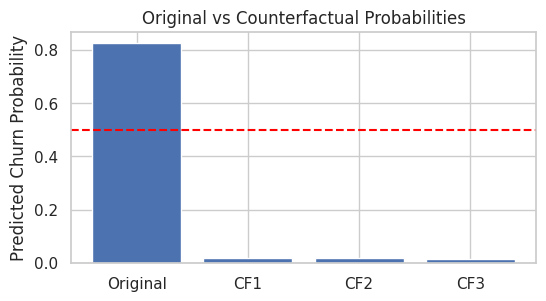


✅ Done. If CFs did not flip class:
   → relax features_to_vary, increase maxiterations, or adjust weights.


In [ ]:

import dice_ml
from dice_ml import Dice
import shap, pandas as pd, numpy as np
import matplotlib.pyplot as plt

src_input = input("Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn': ").strip().lower()
if src_input not in ("churn", "not churn"):
    raise ValueError("Please enter either 'churn' or 'not churn'.")
src_label = 1 if src_input == "churn" else 0

preds_all = rf.predict(X_test)
subset_idx = np.where(preds_all == src_label)[0].tolist()
print(f"\nFound {len(subset_idx)} test samples predicted as '{src_input}'.")
sub_index = int(input(f"Enter subset index (0..{len(subset_idx)-1}): ").strip())
sample_idx = subset_idx[sub_index]

x_instance = X_test.iloc[[sample_idx]]
orig_proba = rf.predict_proba(x_instance)[:,1][0]
orig_pred = int(orig_proba >= 0.5)
print(f"\nSelected global test index: {sample_idx}")
print(f"Original model prediction: {orig_pred} (Prob_Churn={orig_proba:.3f})")

shap_inst = explainer.shap_values(x_instance, check_additivity=False)
class_idx_for_shap = src_label
print("\n SHAP Waterfall for selected instance...\n")
shap.plots.waterfall(
    shap.Explanation(
        values=shap_inst[class_idx_for_shap][0],
        base_values=explainer.expected_value[class_idx_for_shap],
        data=x_instance.iloc[0].values,
        feature_names=X_test.columns
    )
)

fixed_features = {"Age", "Gender_Male", "Gender_Female"}
inst_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Value": x_instance.values[0],
    "SHAP": shap_inst[class_idx_for_shap][0]
})
inst_df["|SHAP|"] = inst_df["SHAP"].abs()
inst_df = inst_df.sort_values("|SHAP|", ascending=False)
print("\nTop 10 SHAP contributions (descending importance):")
display(inst_df.head(10))

inst_df = inst_df[~inst_df["Feature"].isin(fixed_features)]
top_features = inst_df.head(3)["Feature"].tolist()
print(f"\nTop 3 influential features allowed to vary: {top_features}")

def coerce_numeric_df(df):
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype == object:
            uniq = df2[c].dropna().unique().tolist()
            if set(map(str.lower, map(str, uniq))) <= {"true","false"}:
                df2[c] = df2[c].map(lambda v: 1 if str(v).lower()=="true" else 0)
            else:
                df2[c] = pd.to_numeric(df2[c], errors="coerce")
        elif pd.api.types.is_bool_dtype(df2[c]):
            df2[c] = df2[c].astype(int)
    df2 = df2.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df2

X_train_dice = coerce_numeric_df(X_train)
X_test_dice  = coerce_numeric_df(X_test)
y_train_dice = y_train.rename("target")

data_for_dice = pd.concat([X_train_dice, y_train_dice], axis=1)
data_dice = dice_ml.Data(
    dataframe=data_for_dice,
    continuous_features=X_train_dice.columns.tolist(),
    outcome_name="target"
)
model_dice = dice_ml.Model(model=rf, backend="sklearn")
exp = Dice(data_dice, model_dice, method="random")

desired_class = 1 - orig_pred
print(f"\n Generating counterfactuals to flip → class {desired_class} ...\n")

query_row = X_test_dice.iloc[[sample_idx]]

try:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,
        features_to_vary=top_features,
        verbose=True
    )
except TypeError:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,

        features_to_vary=top_features
    )

print("\n=== Counterfactual examples (full rows) ===")
display(dice_cf.cf_examples_list[0].final_cfs_df)

print("\n=== Changed features per counterfactual ===")

try:
    cf_df = dice_cf.cf_examples_list[0].final_cfs_df.copy()
except Exception as e:
    print(" Could not extract CF dataframe:", e)
    cf_df = None

if cf_df is not None:
    q = query_row.iloc[0]
    for i, (_, r) in enumerate(cf_df.iterrows(), start=1):
        changed = {}
        for col in cf_df.columns:
            # Skip non-feature columns
            if col not in q.index or col == "target":
                continue
            ov, nv = q[col], r[col]
            try:
                if not np.isclose(float(ov), float(nv), atol=1e-6):
                    changed[col] = f"{ov} → {nv}"
            except Exception:
                if ov != nv:
                    changed[col] = f"{ov} → {nv}"

        print(f"\n Counterfactual #{i}")
        if changed:
            for feat, change in changed.items():
                print(f"  • {feat}: {change}")
        else:
            print("  (No changes detected)")
else:
    print("No counterfactuals generated.")


rows = [query_row.iloc[0]] + [cf_df.iloc[i] for i in range(len(cf_df))]
labels = ["Original"] + [f"CF{i+1}" for i in range(len(cf_df))]
probs = []
for r in rows:
    r_df = pd.DataFrame([r]).reindex(columns=X_train_dice.columns).fillna(0)
    p = rf.predict_proba(r_df)[:,1][0]
    probs.append(p)
summary = pd.DataFrame({"Instance": labels, "Prob_Churn": np.round(probs,3),
                        "Predicted_Class": (np.array(probs)>=0.5).astype(int)})
print("\n=== Model probabilities for Original and CFs ===")
display(summary)

plt.figure(figsize=(6,3))
plt.bar(summary["Instance"], summary["Prob_Churn"])
plt.axhline(0.5, color="red", linestyle="--")
plt.ylabel("Predicted Churn Probability")
plt.title("Original vs Counterfactual Probabilities")
plt.show()


Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn':  churn



Found 61863 test samples predicted as 'churn'.


Enter subset index (0..61862):  1349



Selected global test index: 2116
Original model prediction: 1 (Prob_Churn=0.826, Prob_NotChurn=0.174)

🔍 Generating SHAP Waterfall plot for selected instance...



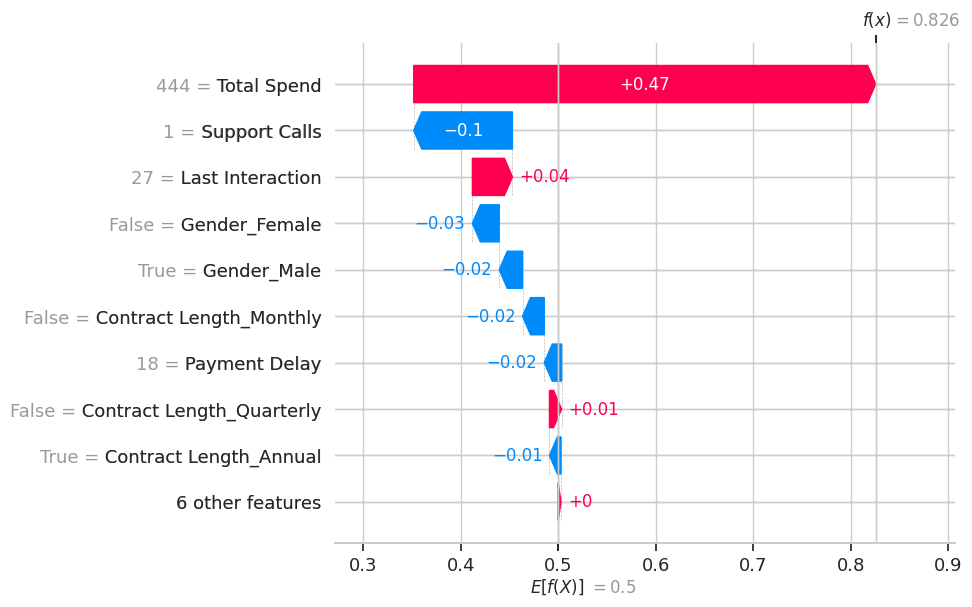


Top 10 SHAP contributions (descending importance):


,Feature,Value,SHAP,|SHAP|
5,Total Spend,444.0,0.473805,0.473805
3,Support Calls,1.0,-0.101259,0.101259
6,Last Interaction,27.0,0.041078,0.041078
7,Gender_Female,False,-0.027551,0.027551
8,Gender_Male,True,-0.023877,0.023877
13,Contract Length_Monthly,False,-0.022299,0.022299
4,Payment Delay,18.0,-0.017760,0.017760
14,Contract Length_Quarterly,False,0.012432,0.012432
12,Contract Length_Annual,True,-0.011822,0.011822
0,Age,23.0,-0.008324,0.008324



Top 3 influential features allowed to vary: ['Total Spend', 'Support Calls', 'Last Interaction']

⚡ Generating counterfactuals to flip → class 0 ...



100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

Diverse Counterfactuals found! total time taken: 00 min 02 sec

=== Counterfactual examples (full rows) ===


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,target
0,23.0,39.0,10.0,1.0,18.0,571.1,27.0,0,1,1,0,0,1,0,0,0.0
1,23.0,39.0,10.0,1.0,18.0,666.6,27.0,0,1,1,0,0,1,0,0,0.0
2,23.0,39.0,10.0,1.0,18.0,936.6,28.5,0,1,1,0,0,1,0,0,0.0



=== Changed features per counterfactual ===

⚡ Counterfactual #1
  • Total Spend: 444.0 → 571.1

⚡ Counterfactual #2
  • Total Spend: 444.0 → 666.6

⚡ Counterfactual #3
  • Total Spend: 444.0 → 936.6
  • Last Interaction: 27.0 → 28.5

=== Model probabilities for Original and CFs ===


,Instance,Prob_NotChurn,Prob_Churn,Predicted_Class
0,Original,0.174,0.826,1
1,CF1,0.984,0.016,0
2,CF2,0.984,0.016,0
3,CF3,0.981,0.019,0


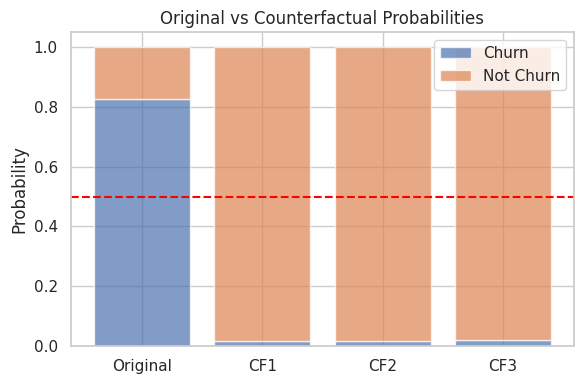

In [ ]:

import dice_ml
from dice_ml import Dice
import shap, pandas as pd, numpy as np
import matplotlib.pyplot as plt

src_input = input("Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn': ").strip().lower()
if src_input not in ("churn", "not churn"):
    raise ValueError("Please enter either 'churn' or 'not churn'.")
src_label = 1 if src_input == "churn" else 0

preds_all = rf.predict(X_test)
subset_idx = np.where(preds_all == src_label)[0].tolist()
print(f"\nFound {len(subset_idx)} test samples predicted as '{src_input}'.")
sub_index = int(input(f"Enter subset index (0..{len(subset_idx)-1}): ").strip())
sample_idx = subset_idx[sub_index]

x_instance = X_test.iloc[[sample_idx]]
orig_proba = rf.predict_proba(x_instance)[0]
orig_pred = int(orig_proba[1] >= 0.5)

print(f"\nSelected global test index: {sample_idx}")
print(f"Original model prediction: {orig_pred} (Prob_Churn={orig_proba[1]:.3f}, Prob_NotChurn={orig_proba[0]:.3f})")

print("\n Generating SHAP Waterfall plot for selected instance...\n")

shap_inst = explainer.shap_values(x_instance, check_additivity=False)
class_idx_for_shap = src_label

shap.plots.waterfall(
    shap.Explanation(
        values=shap_inst[class_idx_for_shap][0],
        base_values=explainer.expected_value[class_idx_for_shap],
        data=x_instance.iloc[0].values,
        feature_names=X_test.columns
    )
)

fixed_features = {"Age", "Gender_Male", "Gender_Female"}
inst_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Value": x_instance.values[0],
    "SHAP": shap_inst[class_idx_for_shap][0]
})
inst_df["|SHAP|"] = inst_df["SHAP"].abs()
inst_df = inst_df.sort_values("|SHAP|", ascending=False)
print("\nTop 10 SHAP contributions (descending importance):")
display(inst_df.head(10))

inst_df = inst_df[~inst_df["Feature"].isin(fixed_features)]
top_features = inst_df.head(3)["Feature"].tolist()
print(f"\nTop 3 influential features allowed to vary: {top_features}")

def coerce_numeric_df(df):
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype == object:
            uniq = df2[c].dropna().unique().tolist()
            if set(map(str.lower, map(str, uniq))) <= {"true", "false"}:
                df2[c] = df2[c].map(lambda v: 1 if str(v).lower() == "true" else 0)
            else:
                df2[c] = pd.to_numeric(df2[c], errors="coerce")
        elif pd.api.types.is_bool_dtype(df2[c]):
            df2[c] = df2[c].astype(int)
    df2 = df2.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df2

X_train_dice = coerce_numeric_df(X_train)
X_test_dice  = coerce_numeric_df(X_test)
y_train_dice = y_train.astype(int).rename("target") 
data_for_dice = pd.concat([X_train_dice, y_train_dice], axis=1)
data_dice = dice_ml.Data(
    dataframe=data_for_dice,
    continuous_features=X_train_dice.columns.tolist(),
    outcome_name="target"
)

model_dice = dice_ml.Model(model=rf, backend="sklearn")
exp = Dice(data_dice, model_dice, method="random")

desired_class = int(1 - orig_pred)  
print(f"\n Generating counterfactuals to flip → class {desired_class} ...\n")

query_row = X_test_dice.iloc[[sample_idx]]

try:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,
        features_to_vary=top_features,
        verbose=True
    )
except TypeError:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,
        features_to_vary=top_features
    )

print("\n=== Counterfactual examples (full rows) ===")
cf_df = dice_cf.cf_examples_list[0].final_cfs_df
display(cf_df)

print("\n=== Changed features per counterfactual ===")
q = query_row.iloc[0]
for i, (_, r) in enumerate(cf_df.iterrows(), start=1):
    changed = {}
    for col in cf_df.columns:
        if col not in q.index or col == "target": 
            continue
        ov, nv = q[col], r[col]
        try:
            if not np.isclose(float(ov), float(nv), atol=1e-6):
                changed[col] = f"{ov} → {nv}"
        except Exception:
            if ov != nv:
                changed[col] = f"{ov} → {nv}"

    print(f"\n Counterfactual #{i}")
    if changed:
        for feat, change in changed.items():
            print(f"  • {feat}: {change}")
    else:
        print("  (No changes detected)")

rows = [query_row.iloc[0]] + [cf_df.iloc[i] for i in range(len(cf_df))]
labels = ["Original"] + [f"CF{i+1}" for i in range(len(cf_df))]

probs_churn, probs_not = [], []
for r in rows:
    r_df = pd.DataFrame([r]).reindex(columns=X_train_dice.columns).fillna(0)
    p = rf.predict_proba(r_df)[0]
    probs_not.append(p[0])
    probs_churn.append(p[1])

summary = pd.DataFrame({
    "Instance": labels,
    "Prob_NotChurn": np.round(probs_not, 3),
    "Prob_Churn": np.round(probs_churn, 3),
    "Predicted_Class": (np.array(probs_churn) >= 0.5).astype(int)
})

print("\n=== Model probabilities for Original and CFs ===")
display(summary)

plt.figure(figsize=(6, 4))
plt.bar(summary["Instance"], summary["Prob_Churn"], label="Churn", alpha=0.7)
plt.bar(summary["Instance"], summary["Prob_NotChurn"], bottom=summary["Prob_Churn"], label="Not Churn", alpha=0.7)
plt.axhline(0.5, color="red", linestyle="--")
plt.ylabel("Probability")
plt.title("Original vs Counterfactual Probabilities")
plt.legend()
plt.tight_layout()
plt.show()


Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn':  not churn



Found 39179 test samples predicted as 'not churn'.


Enter subset index (0..39178):  15457



Selected global test index: 39915
Original model prediction: 0 (Prob_Churn=0.009, Prob_NotChurn=0.991)

🔍 Generating SHAP Waterfall plot for selected instance...



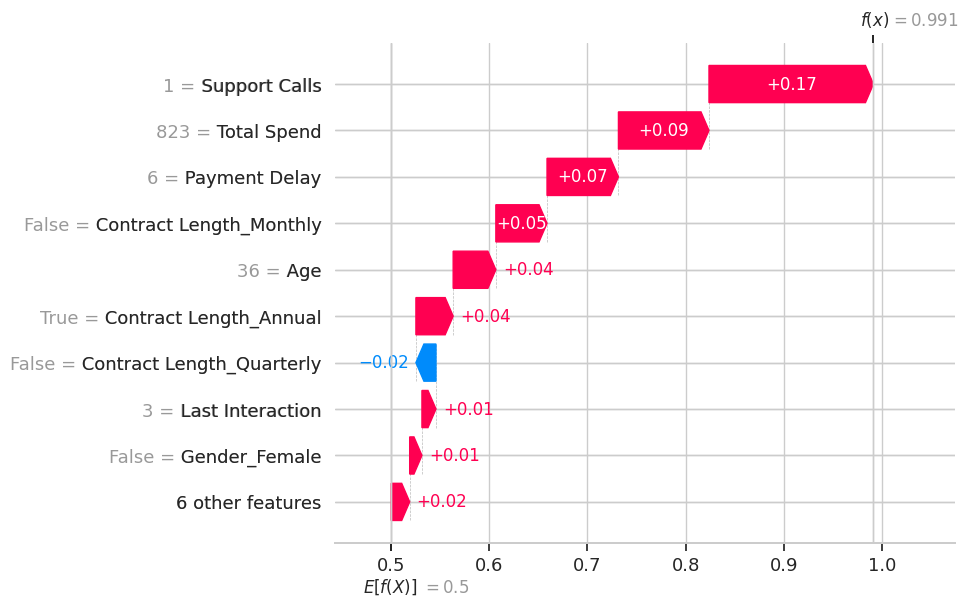


Top 10 SHAP contributions (descending importance):


,Feature,Value,SHAP,|SHAP|
3,Support Calls,1.0,0.167596,0.167596
5,Total Spend,823.0,0.092280,0.092280
4,Payment Delay,6.0,0.072757,0.072757
13,Contract Length_Monthly,False,0.052142,0.052142
0,Age,36.0,0.043497,0.043497
12,Contract Length_Annual,True,0.037957,0.037957
14,Contract Length_Quarterly,False,-0.020447,0.020447
6,Last Interaction,3.0,0.014310,0.014310
7,Gender_Female,False,0.012486,0.012486
8,Gender_Male,True,0.011636,0.011636



Top 3 influential features allowed to vary: ['Support Calls', 'Total Spend', 'Payment Delay']

⚡ Generating counterfactuals to flip → class 1 ...



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

Diverse Counterfactuals found! total time taken: 00 min 01 sec

=== Counterfactual examples (full rows) ===


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,target
0,36.0,60.0,20.0,1.0,17.7,242.7,3.0,0,1,0,0,1,1,0,0,1.0
1,36.0,60.0,20.0,4.2,6.0,618.3,3.0,0,1,0,0,1,1,0,0,1.0
2,36.0,60.0,20.0,1.0,6.0,396.6,3.0,0,1,0,0,1,1,0,0,1.0



=== Changed features per counterfactual ===

⚡ Counterfactual #1
  • Payment Delay: 6.0 → 17.7
  • Total Spend: 823.0 → 242.7

⚡ Counterfactual #2
  • Support Calls: 1.0 → 4.2
  • Total Spend: 823.0 → 618.3

⚡ Counterfactual #3
  • Total Spend: 823.0 → 396.6

=== Model probabilities for Original and CFs ===


,Instance,Prob_NotChurn,Prob_Churn,Predicted_Class
0,Original,0.991,0.009,0
1,CF1,0.201,0.799,1
2,CF2,0.483,0.517,1
3,CF3,0.215,0.785,1


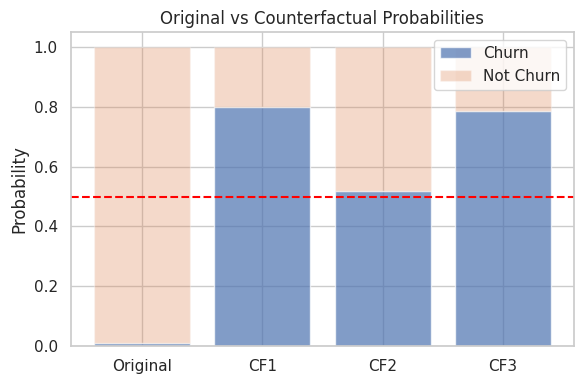

In [ ]:

import dice_ml
from dice_ml import Dice
import shap, pandas as pd, numpy as np
import matplotlib.pyplot as plt

src_input = input("Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn': ").strip().lower()
if src_input not in ("churn", "not churn"):
    raise ValueError("Please enter either 'churn' or 'not churn'.")
src_label = 1 if src_input == "churn" else 0

preds_all = rf.predict(X_test)
subset_idx = np.where(preds_all == src_label)[0].tolist()
print(f"\nFound {len(subset_idx)} test samples predicted as '{src_input}'.")
sub_index = int(input(f"Enter subset index (0..{len(subset_idx)-1}): ").strip())
sample_idx = subset_idx[sub_index]

x_instance = X_test.iloc[[sample_idx]]
orig_proba = rf.predict_proba(x_instance)[0]
orig_pred = int(orig_proba[1] >= 0.5)

print(f"\nSelected global test index: {sample_idx}")
print(f"Original model prediction: {orig_pred} (Prob_Churn={orig_proba[1]:.3f}, Prob_NotChurn={orig_proba[0]:.3f})")

print("\n Generating SHAP Waterfall plot for selected instance...\n")

shap_inst = explainer.shap_values(x_instance, check_additivity=False)
class_idx_for_shap = src_label

shap.plots.waterfall(
    shap.Explanation(
        values=shap_inst[class_idx_for_shap][0],
        base_values=explainer.expected_value[class_idx_for_shap],
        data=x_instance.iloc[0].values,
        feature_names=X_test.columns
    )
)

fixed_features = {"Age", "Gender_Male", "Gender_Female"}
inst_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Value": x_instance.values[0],
    "SHAP": shap_inst[class_idx_for_shap][0]
})
inst_df["|SHAP|"] = inst_df["SHAP"].abs()
inst_df = inst_df.sort_values("|SHAP|", ascending=False)
print("\nTop 10 SHAP contributions (descending importance):")
display(inst_df.head(10))

inst_df = inst_df[~inst_df["Feature"].isin(fixed_features)]
top_features = inst_df.head(3)["Feature"].tolist()
print(f"\nTop 3 influential features allowed to vary: {top_features}")

def coerce_numeric_df(df):
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype == object:
            uniq = df2[c].dropna().unique().tolist()
            if set(map(str.lower, map(str, uniq))) <= {"true", "false"}:
                df2[c] = df2[c].map(lambda v: 1 if str(v).lower() == "true" else 0)
            else:
                df2[c] = pd.to_numeric(df2[c], errors="coerce")
        elif pd.api.types.is_bool_dtype(df2[c]):
            df2[c] = df2[c].astype(int)
    df2 = df2.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df2

X_train_dice = coerce_numeric_df(X_train)
X_test_dice  = coerce_numeric_df(X_test)
y_train_dice = y_train.astype(int).rename("target")  
data_for_dice = pd.concat([X_train_dice, y_train_dice], axis=1)
data_dice = dice_ml.Data(
    dataframe=data_for_dice,
    continuous_features=X_train_dice.columns.tolist(),
    outcome_name="target"
)

model_dice = dice_ml.Model(model=rf, backend="sklearn")
exp = Dice(data_dice, model_dice, method="random")

desired_class = int(1 - orig_pred)  
print(f"\n Generating counterfactuals to flip → class {desired_class} ...\n")

query_row = X_test_dice.iloc[[sample_idx]]

try:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,
        features_to_vary=top_features,
        verbose=True
    )
except TypeError:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,
        features_to_vary=top_features
    )

print("\n=== Counterfactual examples (full rows) ===")
cf_df = dice_cf.cf_examples_list[0].final_cfs_df
display(cf_df)

print("\n=== Changed features per counterfactual ===")
q = query_row.iloc[0]
for i, (_, r) in enumerate(cf_df.iterrows(), start=1):
    changed = {}
    for col in cf_df.columns:
        if col not in q.index or col == "target": 
            continue
        ov, nv = q[col], r[col]
        try:
            if not np.isclose(float(ov), float(nv), atol=1e-6):
                changed[col] = f"{ov} → {nv}"
        except Exception:
            if ov != nv:
                changed[col] = f"{ov} → {nv}"

    print(f"\n Counterfactual #{i}")
    if changed:
        for feat, change in changed.items():
            print(f"  • {feat}: {change}")
    else:
        print("  (No changes detected)")

rows = [query_row.iloc[0]] + [cf_df.iloc[i] for i in range(len(cf_df))]
labels = ["Original"] + [f"CF{i+1}" for i in range(len(cf_df))]

probs_churn, probs_not = [], []
for r in rows:
    r_df = pd.DataFrame([r]).reindex(columns=X_train_dice.columns).fillna(0)
    p = rf.predict_proba(r_df)[0]
    probs_not.append(p[0])
    probs_churn.append(p[1])

summary = pd.DataFrame({
    "Instance": labels,
    "Prob_NotChurn": np.round(probs_not, 3),
    "Prob_Churn": np.round(probs_churn, 3),
    "Predicted_Class": (np.array(probs_churn) >= 0.5).astype(int)
})

print("\n=== Model probabilities for Original and CFs ===")
display(summary)

plt.figure(figsize=(6, 4))
plt.bar(summary["Instance"], summary["Prob_Churn"], label="Churn", alpha=0.7)
plt.bar(summary["Instance"], summary["Prob_NotChurn"], bottom=summary["Prob_Churn"], label="Not Churn", alpha=0.5)
plt.axhline(0.5, color="red", linestyle="--")
plt.ylabel("Probability")
plt.title("Original vs Counterfactual Probabilities")
plt.legend()
plt.tight_layout()
plt.show()


Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn':  churn



Found 61863 test samples predicted as 'churn'.


Enter subset index (0..61862):  7302



Selected global test index: 11916
Original model prediction: 1 (Prob_Churn=0.837, Prob_NotChurn=0.163)

🔍 Generating SHAP Waterfall plot for selected instance...



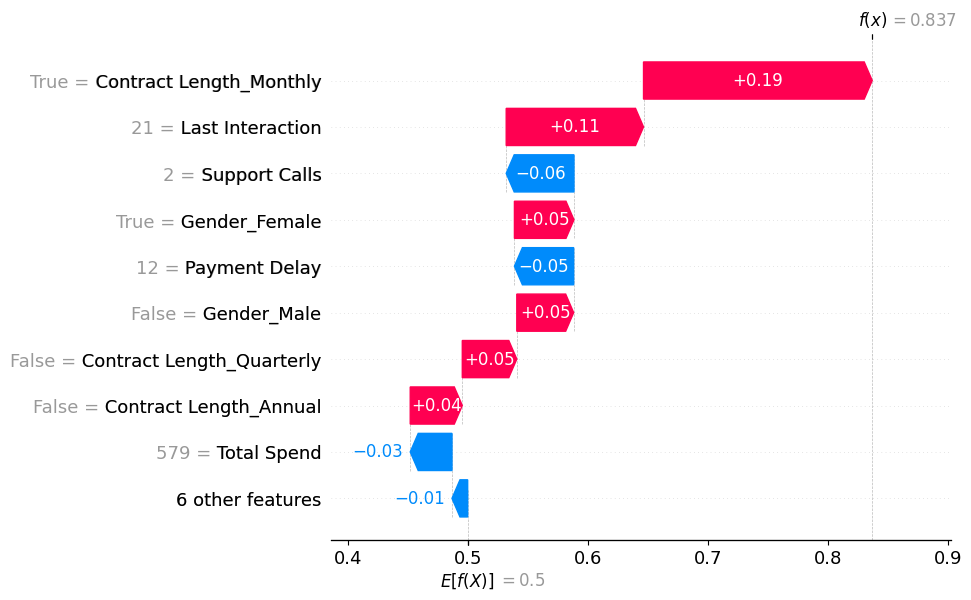


Top 10 SHAP contributions (descending importance):


,Feature,Value,SHAP,|SHAP|
13,Contract Length_Monthly,True,0.190571,0.190571
6,Last Interaction,21.0,0.114417,0.114417
3,Support Calls,2.0,-0.056468,0.056468
7,Gender_Female,True,0.049622,0.049622
4,Payment Delay,12.0,-0.049371,0.049371
8,Gender_Male,False,0.047388,0.047388
14,Contract Length_Quarterly,False,0.045421,0.045421
12,Contract Length_Annual,False,0.043386,0.043386
5,Total Spend,579.0,-0.034803,0.034803
0,Age,43.0,-0.026871,0.026871



Top 3 influential features allowed to vary: ['Contract Length_Monthly', 'Last Interaction', 'Support Calls']

⚡ Generating counterfactuals to flip → class 0 ...



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

Diverse Counterfactuals found! total time taken: 00 min 01 sec

=== Counterfactual examples (full rows) ===


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,target
0,43.0,10.0,3.0,2.0,12.0,579.0,9.4,1,0,0,1,0,0,0,0,0.0
1,43.0,10.0,3.0,2.0,12.0,579.0,4.7,1,0,0,1,0,0,0,0,0.0
2,43.0,10.0,3.0,2.0,12.0,579.0,15.2,1,0,0,1,0,0,0,0,0.0



=== Changed features per counterfactual ===

⚡ Counterfactual #1
  • Last Interaction: 21.0 → 9.4
  • Contract Length_Monthly: 1.0 → 0.0

⚡ Counterfactual #2
  • Last Interaction: 21.0 → 4.7
  • Contract Length_Monthly: 1.0 → 0.0

⚡ Counterfactual #3
  • Last Interaction: 21.0 → 15.2
  • Contract Length_Monthly: 1.0 → 0.0

=== Model probabilities for Original and CFs ===


,Instance,Prob_NotChurn,Prob_Churn,Predicted_Class
0,Original,0.163,0.837,1
1,CF1,0.749,0.251,0
2,CF2,0.748,0.252,0
3,CF3,0.745,0.255,0


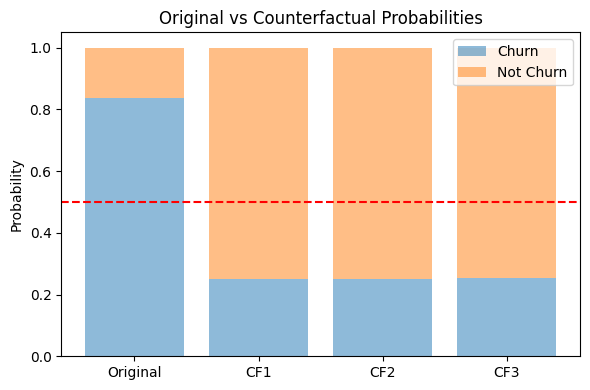

In [ ]:

import dice_ml
from dice_ml import Dice
import shap, pandas as pd, numpy as np
import matplotlib.pyplot as plt

src_input = input("Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn': ").strip().lower()
if src_input not in ("churn", "not churn"):
    raise ValueError("Please enter either 'churn' or 'not churn'.")
src_label = 1 if src_input == "churn" else 0

preds_all = rf.predict(X_test)
subset_idx = np.where(preds_all == src_label)[0].tolist()
print(f"\nFound {len(subset_idx)} test samples predicted as '{src_input}'.")
sub_index = int(input(f"Enter subset index (0..{len(subset_idx)-1}): ").strip())
sample_idx = subset_idx[sub_index]

x_instance = X_test.iloc[[sample_idx]]
orig_proba = rf.predict_proba(x_instance)[0]
orig_pred = int(orig_proba[1] >= 0.5)

print(f"\nSelected global test index: {sample_idx}")
print(f"Original model prediction: {orig_pred} (Prob_Churn={orig_proba[1]:.3f}, Prob_NotChurn={orig_proba[0]:.3f})")

print("\n Generating SHAP Waterfall plot for selected instance...\n")

shap_inst = explainer.shap_values(x_instance, check_additivity=False)
class_idx_for_shap = src_label

shap.plots.waterfall(
    shap.Explanation(
        values=shap_inst[class_idx_for_shap][0],
        base_values=explainer.expected_value[class_idx_for_shap],
        data=x_instance.iloc[0].values,
        feature_names=X_test.columns
    )
)

fixed_features = {"Age", "Gender_Male", "Gender_Female"}
inst_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Value": x_instance.values[0],
    "SHAP": shap_inst[class_idx_for_shap][0]
})
inst_df["|SHAP|"] = inst_df["SHAP"].abs()
inst_df = inst_df.sort_values("|SHAP|", ascending=False)
print("\nTop 10 SHAP contributions (descending importance):")
display(inst_df.head(10))

inst_df = inst_df[~inst_df["Feature"].isin(fixed_features)]
top_features = inst_df.head(3)["Feature"].tolist()
print(f"\nTop 3 influential features allowed to vary: {top_features}")

def coerce_numeric_df(df):
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype == object:
            uniq = df2[c].dropna().unique().tolist()
            if set(map(str.lower, map(str, uniq))) <= {"true", "false"}:
                df2[c] = df2[c].map(lambda v: 1 if str(v).lower() == "true" else 0)
            else:
                df2[c] = pd.to_numeric(df2[c], errors="coerce")
        elif pd.api.types.is_bool_dtype(df2[c]):
            df2[c] = df2[c].astype(int)
    df2 = df2.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df2

X_train_dice = coerce_numeric_df(X_train)
X_test_dice  = coerce_numeric_df(X_test)
y_train_dice = y_train.astype(int).rename("target")  
data_for_dice = pd.concat([X_train_dice, y_train_dice], axis=1)
data_dice = dice_ml.Data(
    dataframe=data_for_dice,
    continuous_features=X_train_dice.columns.tolist(),
    outcome_name="target"
)

model_dice = dice_ml.Model(model=rf, backend="sklearn")
exp = Dice(data_dice, model_dice, method="random")

desired_class = int(1 - orig_pred)  
print(f"\n Generating counterfactuals to flip → class {desired_class} ...\n")

query_row = X_test_dice.iloc[[sample_idx]]

try:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,
        features_to_vary=top_features,
        verbose=True
    )
except TypeError:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,
        features_to_vary=top_features
    )

print("\n=== Counterfactual examples (full rows) ===")
cf_df = dice_cf.cf_examples_list[0].final_cfs_df
display(cf_df)

print("\n=== Changed features per counterfactual ===")
q = query_row.iloc[0]
for i, (_, r) in enumerate(cf_df.iterrows(), start=1):
    changed = {}
    for col in cf_df.columns:
        if col not in q.index or col == "target": 
            continue
        ov, nv = q[col], r[col]
        try:
            if not np.isclose(float(ov), float(nv), atol=1e-6):
                changed[col] = f"{ov} → {nv}"
        except Exception:
            if ov != nv:
                changed[col] = f"{ov} → {nv}"

    print(f"\n Counterfactual #{i}")
    if changed:
        for feat, change in changed.items():
            print(f"  • {feat}: {change}")
    else:
        print("  (No changes detected)")

rows = [query_row.iloc[0]] + [cf_df.iloc[i] for i in range(len(cf_df))]
labels = ["Original"] + [f"CF{i+1}" for i in range(len(cf_df))]

probs_churn, probs_not = [], []
for r in rows:
    r_df = pd.DataFrame([r]).reindex(columns=X_train_dice.columns).fillna(0)
    p = rf.predict_proba(r_df)[0]
    probs_not.append(p[0])
    probs_churn.append(p[1])

summary = pd.DataFrame({
    "Instance": labels,
    "Prob_NotChurn": np.round(probs_not, 3),
    "Prob_Churn": np.round(probs_churn, 3),
    "Predicted_Class": (np.array(probs_churn) >= 0.5).astype(int)
})

print("\n=== Model probabilities for Original and CFs ===")
display(summary)

plt.figure(figsize=(6, 4))
plt.bar(summary["Instance"], summary["Prob_Churn"], label="Churn", alpha=0.5)
plt.bar(summary["Instance"], summary["Prob_NotChurn"], bottom=summary["Prob_Churn"], label="Not Churn", alpha=0.5)
plt.axhline(0.5, color="red", linestyle="--")
plt.ylabel("Probability")
plt.title("Original vs Counterfactual Probabilities")
plt.legend()
plt.tight_layout()
plt.show()


Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn':  not churn



Found 39179 test samples predicted as 'not churn'.


Enter subset index (0..39178):  1345



Selected global test index: 3553
Original model prediction: 0 (Prob_Churn=0.011, Prob_NotChurn=0.989)

🔍 Generating SHAP Waterfall plot for selected instance...



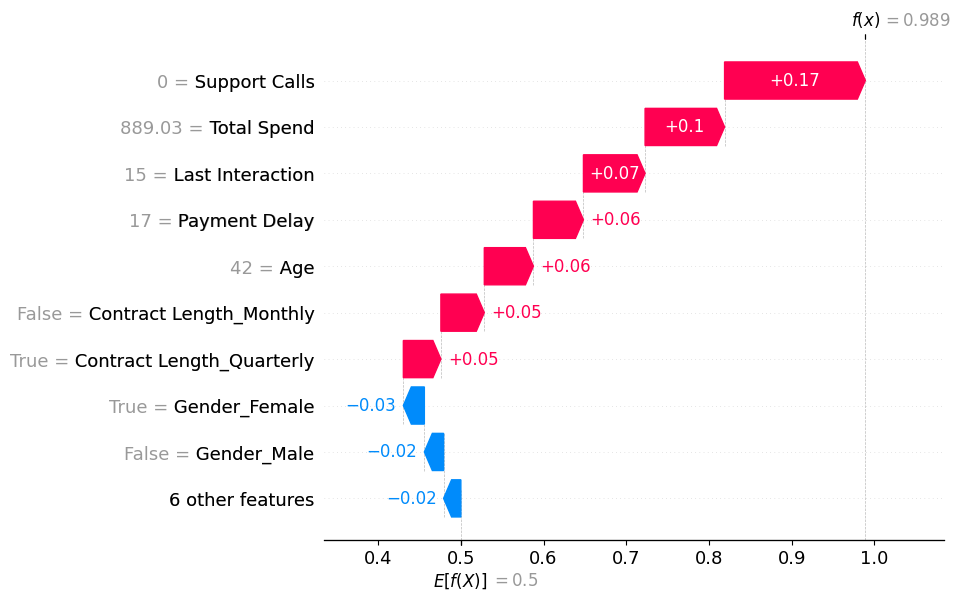


Top 10 SHAP contributions (descending importance):


,Feature,Value,SHAP,|SHAP|
3,Support Calls,0.0,0.170183,0.170183
5,Total Spend,889.03,0.096108,0.096108
6,Last Interaction,15.0,0.074526,0.074526
4,Payment Delay,17.0,0.060455,0.060455
0,Age,42.0,0.059397,0.059397
13,Contract Length_Monthly,False,0.052476,0.052476
14,Contract Length_Quarterly,True,0.045391,0.045391
7,Gender_Female,True,-0.025396,0.025396
8,Gender_Male,False,-0.023272,0.023272
12,Contract Length_Annual,False,-0.021910,0.021910



Top 3 influential features allowed to vary: ['Support Calls', 'Total Spend', 'Last Interaction']

⚡ Generating counterfactuals to flip → class 1 ...



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Diverse Counterfactuals found! total time taken: 00 min 01 sec

=== Counterfactual examples (full rows) ===


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,target
0,42.0,49.0,6.0,7.7,17.0,552.60,15.0,1,0,0,1,0,0,0,1,1.0
1,42.0,49.0,6.0,7.8,17.0,889.03,27.2,1,0,0,1,0,0,0,1,1.0
2,42.0,49.0,6.0,1.7,17.0,889.03,26.5,1,0,0,1,0,0,0,1,1.0



=== Changed features per counterfactual ===

⚡ Counterfactual #1
  • Support Calls: 0.0 → 7.7
  • Total Spend: 889.03 → 552.6

⚡ Counterfactual #2
  • Support Calls: 0.0 → 7.8
  • Last Interaction: 15.0 → 27.2

⚡ Counterfactual #3
  • Support Calls: 0.0 → 1.7
  • Last Interaction: 15.0 → 26.5

=== Model probabilities for Original and CFs ===


,Instance,Prob_NotChurn,Prob_Churn,Predicted_Class
0,Original,0.989,0.011,0
1,CF1,0.053,0.947,1
2,CF2,0.024,0.976,1
3,CF3,0.268,0.732,1


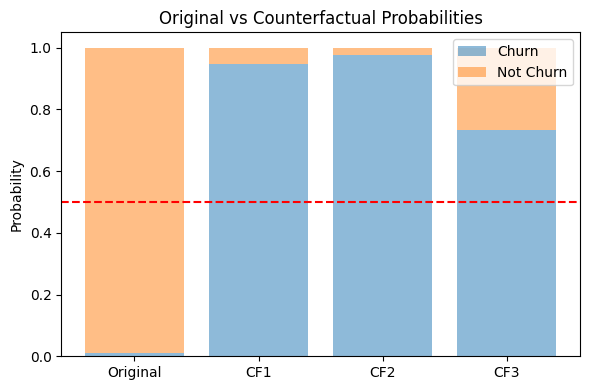

In [ ]:

import dice_ml
from dice_ml import Dice
import shap, pandas as pd, numpy as np
import matplotlib.pyplot as plt

src_input = input("Which SOURCE class do you want to inspect? Enter 'churn' or 'not churn': ").strip().lower()
if src_input not in ("churn", "not churn"):
    raise ValueError("Please enter either 'churn' or 'not churn'.")
src_label = 1 if src_input == "churn" else 0

preds_all = rf.predict(X_test)
subset_idx = np.where(preds_all == src_label)[0].tolist()
print(f"\nFound {len(subset_idx)} test samples predicted as '{src_input}'.")
sub_index = int(input(f"Enter subset index (0..{len(subset_idx)-1}): ").strip())
sample_idx = subset_idx[sub_index]

x_instance = X_test.iloc[[sample_idx]]
orig_proba = rf.predict_proba(x_instance)[0]
orig_pred = int(orig_proba[1] >= 0.5)

print(f"\nSelected global test index: {sample_idx}")
print(f"Original model prediction: {orig_pred} (Prob_Churn={orig_proba[1]:.3f}, Prob_NotChurn={orig_proba[0]:.3f})")

print("\n Generating SHAP Waterfall plot for selected instance...\n")

shap_inst = explainer.shap_values(x_instance, check_additivity=False)
class_idx_for_shap = src_label

shap.plots.waterfall(
    shap.Explanation(
        values=shap_inst[class_idx_for_shap][0],
        base_values=explainer.expected_value[class_idx_for_shap],
        data=x_instance.iloc[0].values,
        feature_names=X_test.columns
    )
)

fixed_features = {"Age", "Gender_Male", "Gender_Female"}
inst_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Value": x_instance.values[0],
    "SHAP": shap_inst[class_idx_for_shap][0]
})
inst_df["|SHAP|"] = inst_df["SHAP"].abs()
inst_df = inst_df.sort_values("|SHAP|", ascending=False)
print("\nTop 10 SHAP contributions (descending importance):")
display(inst_df.head(10))

inst_df = inst_df[~inst_df["Feature"].isin(fixed_features)]
top_features = inst_df.head(3)["Feature"].tolist()
print(f"\nTop 3 influential features allowed to vary: {top_features}")

def coerce_numeric_df(df):
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype == object:
            uniq = df2[c].dropna().unique().tolist()
            if set(map(str.lower, map(str, uniq))) <= {"true", "false"}:
                df2[c] = df2[c].map(lambda v: 1 if str(v).lower() == "true" else 0)
            else:
                df2[c] = pd.to_numeric(df2[c], errors="coerce")
        elif pd.api.types.is_bool_dtype(df2[c]):
            df2[c] = df2[c].astype(int)
    df2 = df2.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df2

X_train_dice = coerce_numeric_df(X_train)
X_test_dice  = coerce_numeric_df(X_test)
y_train_dice = y_train.astype(int).rename("target") 

data_for_dice = pd.concat([X_train_dice, y_train_dice], axis=1)
data_dice = dice_ml.Data(
    dataframe=data_for_dice,
    continuous_features=X_train_dice.columns.tolist(),
    outcome_name="target"
)

model_dice = dice_ml.Model(model=rf, backend="sklearn")
exp = Dice(data_dice, model_dice, method="random")

desired_class = int(1 - orig_pred) 
print(f"\n Generating counterfactuals to flip → class {desired_class} ...\n")

query_row = X_test_dice.iloc[[sample_idx]]

try:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,
        features_to_vary=top_features,
        verbose=True
    )
except TypeError:
    dice_cf = exp.generate_counterfactuals(
        query_row,
        total_CFs=3,
        desired_class=desired_class,
        features_to_vary=top_features
    )

print("\n=== Counterfactual examples (full rows) ===")
cf_df = dice_cf.cf_examples_list[0].final_cfs_df
display(cf_df)

print("\n=== Changed features per counterfactual ===")
q = query_row.iloc[0]
for i, (_, r) in enumerate(cf_df.iterrows(), start=1):
    changed = {}
    for col in cf_df.columns:
        if col not in q.index or col == "target": 
            continue
        ov, nv = q[col], r[col]
        try:
            if not np.isclose(float(ov), float(nv), atol=1e-6):
                changed[col] = f"{ov} → {nv}"
        except Exception:
            if ov != nv:
                changed[col] = f"{ov} → {nv}"

    print(f"\n Counterfactual #{i}")
    if changed:
        for feat, change in changed.items():
            print(f"  • {feat}: {change}")
    else:
        print("  (No changes detected)")

rows = [query_row.iloc[0]] + [cf_df.iloc[i] for i in range(len(cf_df))]
labels = ["Original"] + [f"CF{i+1}" for i in range(len(cf_df))]

probs_churn, probs_not = [], []
for r in rows:
    r_df = pd.DataFrame([r]).reindex(columns=X_train_dice.columns).fillna(0)
    p = rf.predict_proba(r_df)[0]
    probs_not.append(p[0])
    probs_churn.append(p[1])

summary = pd.DataFrame({
    "Instance": labels,
    "Prob_NotChurn": np.round(probs_not, 3),
    "Prob_Churn": np.round(probs_churn, 3),
    "Predicted_Class": (np.array(probs_churn) >= 0.5).astype(int)
})

print("\n=== Model probabilities for Original and CFs ===")
display(summary)

plt.figure(figsize=(6, 4))
plt.bar(summary["Instance"], summary["Prob_Churn"], label="Churn", alpha=0.5)
plt.bar(summary["Instance"], summary["Prob_NotChurn"], bottom=summary["Prob_Churn"], label="Not Churn", alpha=0.5)
plt.axhline(0.5, color="red", linestyle="--")
plt.ylabel("Probability")
plt.title("Original vs Counterfactual Probabilities")
plt.legend()
plt.tight_layout()
plt.show()
